In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.interpolate import interp1d

In [2]:
df_rd = pd.read_csv('roads_transposed.csv')
df_rd.head(5)

,road,lrp,lat,lon
0,N1,LRPS,23.706028,90.443333
1,N1,LRPSa,23.702917,90.450417
2,N1,LRPSb,23.702778,90.450472
3,N1,LRP001,23.702139,90.451972
4,N1,LRP002,23.697889,90.460583


### CLEANING FUNCTIONS

In [3]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # radius of the Earth in kilometers
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    a = np.sin(dlat / 2) ** 2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c
    return distance # in kilometers

def calc_lrp_distance(df):
    # lrp before
    df_lrp_before = df.shift(1)
    
    # euclidean distance
    #lrp_distance = np.sqrt((df_lrp_before['lat'] - df['lat'])**2 + (df_lrp_before['lon'] - df['lon'])**2)

    # haversine distance
    lrp_distance = df.apply(lambda row: haversine(row['lat'], 
                                                  row['lon'], df_lrp_before.loc[row.name, 'lat'], 
                                                  df_lrp_before.loc[row.name, 'lon']), axis=1)

    return lrp_distance

'''def get_lrp_offroad(lrp_distance, q_threshold=0.85):
    # set threshold
    threshold = lrp_distance.quantile(q_threshold)
    #print(threshold)

    # both edges before and after the lrp are >>>
    lrp_offroad = lrp_distance.loc[(lrp_distance > threshold) & (lrp_distance.shift(-1) > threshold)]
    
    return lrp_offroad'''

def get_lrp_offroad(df, lrp_distance, q_threshold=0.85):
    threshold = lrp_distance.quantile(q_threshold)
    lrp_offroad = []

    for i in range(1, len(df) - 1):
        if lrp_distance.iloc[i] > threshold or lrp_distance.iloc[i + 1] > threshold:
            lrp_offroad.append(i)
    
    print(f'Found {len(lrp_offroad)} offroad LRP points')
    return lrp_offroad

'''def fix_offroad_lrp(df, lrp_offroad):
    # make sure not to overwrite the original df -> result in an annoying warning
    #df_copy = df.copy()
    
    # lat = 1/2 x (lat before + lat after)
    df['lat'].loc[lrp_offroad.index] = 0.5 * (df['lat'].shift(1).loc[lrp_offroad.index] + df['lat'].shift(-1).loc[lrp_offroad.index])
    # lon = 1/2 x (lon before + lon after)
    df['lon'].loc[lrp_offroad.index] = 0.5 * (df['lon'].shift(1).loc[lrp_offroad.index] + df['lon'].shift(-1).loc[lrp_offroad.index])

    return df'''

def fix_offroad_lrp(df, lrp_offroad):
    i = 0
    while i < len(lrp_offroad):
        start = lrp_offroad[i] - 1
        end = lrp_offroad[i]
        while i + 1 < len(lrp_offroad) and lrp_offroad[i + 1] == lrp_offroad[i] + 1:
            end = lrp_offroad[i + 1]
            i += 1
        end += 1
        
        # Get the non-outlier points before and after the lrp_offroad
        lat_before = df.iloc[start]['lat']
        lon_before = df.iloc[start]['lon']
        lat_after = df.iloc[end]['lat']
        lon_after = df.iloc[end]['lon']
        
        # Interpolate using spline
        x = [start, end]
        lat_y = [lat_before, lat_after]
        lon_y = [lon_before, lon_after]
        
        lat_spline = interp1d(x, lat_y, kind='linear')
        lon_spline = interp1d(x, lon_y, kind='linear')
        
        for j in range(start + 1, end):
            df.at[j, 'lat'] = lat_spline(j)
            df.at[j, 'lon'] = lon_spline(j)
        
        i += 1
    return df

def process_offroad_lrp(df, q_threshold):

    lrp_distance = calc_lrp_distance(df)
    lrp_offroad = get_lrp_offroad(df, lrp_distance, q_threshold)
    fixed_df = fix_offroad_lrp(df, lrp_offroad)

    return fixed_df

### PLOT FUNCTIONS

In [4]:
def plot_road(df):
    plt.figure(figsize=(6, 4))
    plt.scatter(df['lon'], df['lat'], color='y', alpha=0.7,
                label='lrp')
    plt.plot(df['lon'], df['lat'], color='k', alpha=1, linewidth=1,
            label='road')
        
    # Annotate each point with the 'lrp' label
    #for i, row in df.iterrows():
     #   plt.annotate(row['lrp'], (row['lon'], row['lat']), textcoords="offset points", xytext=(0, 5), ha='center')
        
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Road Line Plot')
    plt.legend()
    plt

    plt.show()

def plot_roadname(df):
    plt.figure(figsize=(6, 4))
    plt.scatter(df['lon'], df['lat'], color='y', alpha=0.7,
                label='lrp')
    plt.plot(df['lon'], df['lat'], color='k', alpha=1, linewidth=1,
            label='road')
        
    # Annotate each point with the 'lrp' label
    for i, row in df.iterrows():
        plt.annotate(row['lrp'], (row['lon'], row['lat']), textcoords="offset points", xytext=(0, 5), 
                     ha='center', fontsize=6, alpha=0.7)
        
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Road Line Plot')
    plt.legend()
    plt

    plt.show()

def plot_map(df_rd):
    plt.figure(figsize=(10, 10))

    for idx, (road, group) in enumerate(df_rd.groupby('road')):
        plt.plot(group['lon'], group['lat'], 'o-', markersize=3)

    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

def plot_road_comparison(df_original, df_corrected, road):
    fig, axes = plt.subplots(1, 2, figsize=(15, 7))
    
    # Plot original road
    df_road_original = df_original[df_original['road'] == road]
    axes[0].scatter(df_road_original['lon'], df_road_original['lat'], color='y', alpha=0.7, label='lrp')
    axes[0].plot(df_road_original['lon'], df_road_original['lat'], color='k', alpha=1, linewidth=1, label='road')
    axes[0].set_title(f'{road} - Original')
    axes[0].set_xlabel('Longitude')
    axes[0].set_ylabel('Latitude')
    axes[0].legend()
    
    # Plot corrected road
    df_road_corrected = df_corrected[df_corrected['road'] == road]
    axes[1].scatter(df_road_corrected['lon'], df_road_corrected['lat'], color='y', alpha=0.7, label='lrp')
    axes[1].plot(df_road_corrected['lon'], df_road_corrected['lat'], color='k', alpha=1, linewidth=1, label='road')
    axes[1].set_title(f'{road} - Interpolated')
    axes[1].set_xlabel('Longitude')
    axes[1].set_ylabel('Latitude')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

In [5]:
n1 = df_rd.groupby('road').get_group('N1')
n1

,road,lrp,lat,lon
0,N1,LRPS,23.706028,90.443333
1,N1,LRPSa,23.702917,90.450417
2,N1,LRPSb,23.702778,90.450472
3,N1,LRP001,23.702139,90.451972
4,N1,LRP002,23.697889,90.460583
...,...,...,...,...
1343,N1,LRP466a,20.868860,92.298222
1344,N1,LRP466b,20.865028,92.298250
1345,N1,LRP466c,20.864667,92.298194
1346,N1,LRP467,20.862972,92.298083


In [6]:
n1_neo = process_offroad_lrp(n1, q_threshold=0.85)

Found 343 offroad LRP points


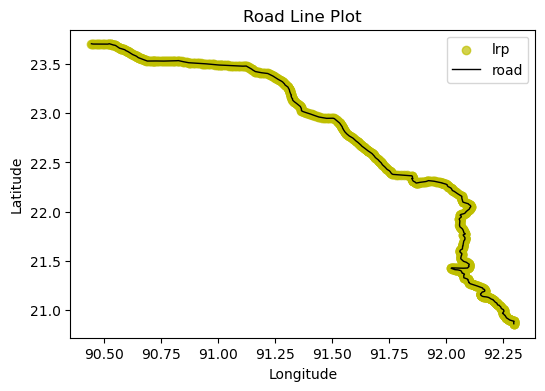

In [7]:
plot_road(n1_neo)

In [8]:
# Example usage
df_rd = pd.read_csv('roads_transposed.csv')  # Load your data
roads = df_rd['road'].unique()

# Make a copy of the original data before fixing
df_rd_original = df_rd.copy()

for road in roads:
    df_road = df_rd[df_rd['road'] == road].reset_index(drop=True)
    lrp_distance = calc_lrp_distance(df_road)
    lrp_offroad = get_lrp_offroad(df_road, lrp_distance, q_threshold=0.85)

    print(f"Outliers for road {road}: {lrp_offroad}")  # Debug print statement
    df_road_corrected = fix_offroad_lrp(df_road, lrp_offroad)
    df_rd.loc[df_rd['road'] == road, ['lat', 'lon']] = df_road[['lat', 'lon']].values

# Save the corrected dataframe
df_rd.to_csv('roads_corrected.csv', index=False)

Found 343 offroad LRP points
Outliers for road N1: [1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 30, 31, 32, 33, 34, 53, 54, 60, 61, 62, 63, 64, 65, 68, 69, 70, 92, 93, 99, 100, 107, 108, 109, 110, 111, 112, 114, 115, 116, 117, 118, 120, 121, 123, 124, 127, 128, 131, 132, 134, 135, 136, 137, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 153, 154, 155, 157, 158, 160, 161, 162, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 183, 184, 188, 189, 190, 191, 192, 193, 198, 199, 200, 205, 206, 209, 210, 211, 212, 213, 215, 216, 217, 218, 219, 221, 222, 224, 225, 226, 227, 232, 233, 234, 237, 238, 240, 241, 252, 253, 254, 255, 260, 261, 267, 268, 277, 278, 279, 280, 289, 290, 297, 298, 303, 304, 316, 317, 323, 324, 332, 333, 338, 339, 340, 342, 343, 346, 347, 348, 349, 350, 352, 353, 354, 355, 357, 358, 359, 364, 365, 366, 367, 378, 379, 380, 381, 385, 386, 387, 398, 399, 400, 401, 406, 407, 410, 411, 421, 422, 425, 426, 427, 428, 429, 430, 442, 443, 463, 464, 466, 467, 47

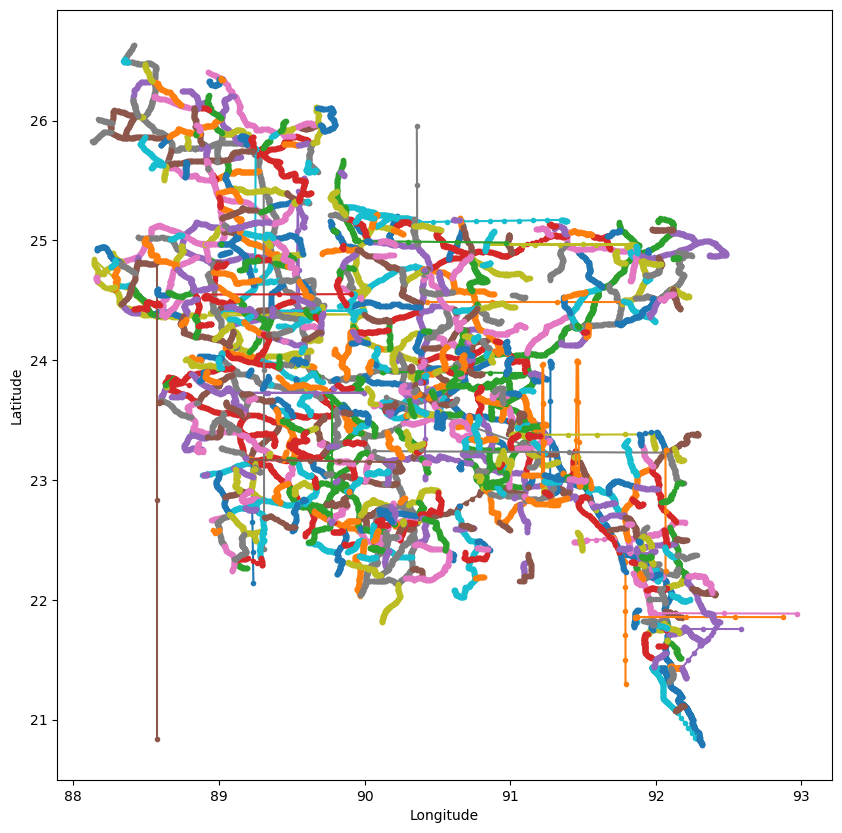

In [9]:
df_new = pd.read_csv('roads_corrected.csv')
plot_map(df_new)

In [10]:
# Example usage
df_rd1 = pd.read_csv('roads_corrected.csv')  # Load your data
roads = df_rd1['road'].unique()

# Make a copy of the original data before fixing
df_rd_original = df_rd1.copy()

# calculate threshold ND interpolate per proad
for road in roads:
    df_road = df_rd1[df_rd1['road'] == road].reset_index(drop=True)
    lrp_distance = calc_lrp_distance(df_road)
    lrp_offroad = get_lrp_offroad(df_road, lrp_distance, q_threshold=0.95)

    print(f"Outliers for road {road}: {lrp_offroad}")  # Debug print statement
    df_road_corrected = fix_offroad_lrp(df_road, lrp_offroad)
    df_rd1.loc[df_rd1['road'] == road, ['lat', 'lon']] = df_road[['lat', 'lon']].values

# Save the corrected dataframe
df_rd1.to_csv('roads_corrected2.csv', index=False)

Found 103 offroad LRP points
Outliers for road N1: [17, 18, 126, 127, 128, 129, 133, 134, 135, 136, 137, 138, 164, 165, 230, 231, 275, 276, 291, 292, 305, 306, 310, 311, 329, 330, 334, 335, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 363, 364, 365, 366, 367, 368, 390, 391, 447, 448, 483, 484, 486, 487, 523, 524, 565, 566, 567, 568, 569, 570, 571, 572, 584, 585, 588, 589, 622, 623, 714, 715, 716, 797, 798, 800, 801, 842, 843, 850, 851, 852, 853, 854, 867, 868, 869, 870, 871, 897, 898, 920, 921, 1061, 1062, 1083, 1084, 1256, 1257, 1281, 1282, 1333, 1334]
Found 2 offroad LRP points
Outliers for road N101: [14, 15]
Found 20 offroad LRP points
Outliers for road N102: [21, 22, 49, 50, 57, 58, 88, 89, 115, 116, 117, 118, 137, 138, 187, 188, 197, 198, 215, 216]
Found 2 offroad LRP points
Outliers for road N103: [5, 6]
Found 12 offroad LRP points
Outliers for road N104: [2, 3, 33, 34, 42, 43, 44, 45, 46, 47, 118, 119]
Found 9 offroad LRP points
Outliers for road N105: [19, 20, 3

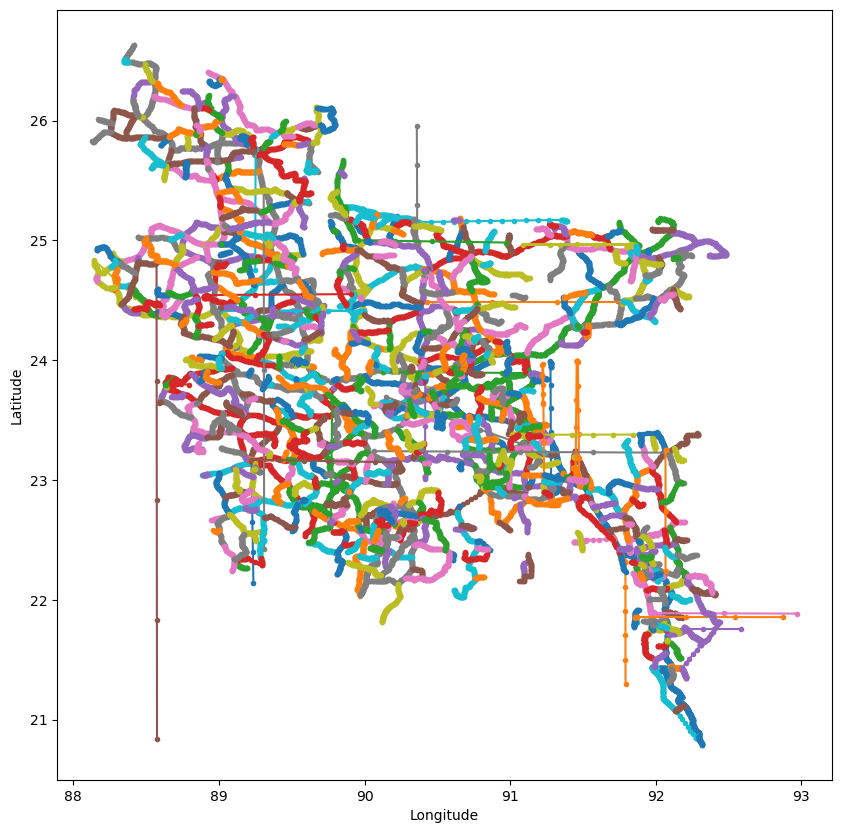

In [11]:
df_new1 = pd.read_csv('roads_corrected2.csv')
plot_map(df_new1)

In [12]:
#for road in roads:
 #   plot_road_comparison(df_rd_original, df_new1, road)